<a href="https://colab.research.google.com/github/yhfga18/ML_stuff/blob/main/8_RNN_name_classification_10_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

Classify names into the country 

1. prepare data (one hot encoding)
2. define RNN model 
3. train it 
4. try it yourself

In [ ]:
# Imports
import torch
import torchvision
import torch.nn as nn # NN modules (nn.Linear, nn.Conv2d, BatchNorm, Loss functions)
import torch.optim as optim # Optimization algorithms, SGD, Adam, etc
import torch.nn.functional as F # Functions with no parameters (activation # Relu Tanh)
from torch.utils.data import DataLoader # Gives easier dataset management and create mini batches
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset

In [ ]:
# *** line = name. sorry for confusion 

# Utility Functions
# to convert all letters and unicode to ASCII 
# to convert letter, word, sentence to one hot encoding 

# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random


# ===========================================================
# Helper func for converting letters/unicode to ASCII 


# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

# ===========================================================
# load data 

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('name_data/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories


# ===========================================================
# one hot vector

# To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. 
# A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
# To make a word, we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.
# That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.


# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    # ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch 
import torch.nn as NN
import matplotlib.pyplot as plt

In [ ]:
# implement RNN from scratch, although RNN module is available in pytorch
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        #i2h = input2hidden. input = input size + hidden size, output = hidden size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) 
        
        #i20 = input2output. the same as above, except later apply Softmax
        self.i2o = nn.Linear(input_size + hidden_size, output_size) 
        
        self.softmax = nn.LogSoftmax(dim=1) # 1, 57

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    # need initial hidden at the first step 
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [ ]:
# RNN(input_size, hidden_size, output_size)
n_hidden = 128 # hyper parameter so somewhat arbitrary 
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [ ]:
# one single letter, one step

input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
# one single line, one step

input_tensor = line_to_tensor('John')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
# helper function to apply the model above to all characters in line

# return the highest index of the output tensor (one-hot)
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Dutch


In [ ]:
# train the model 

loss_func = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)


 # one traning step:

# line_tensor = the name, category_tensor = class label
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]): # length of name 
        output, hidden = rnn(line_tensor[i], hidden) # current character & prev hidden

    loss = loss_func(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

# typical training loop

current_loss = 0
all_losses = [] # to plot later
plot_steps, print_steps = 1000, 5000
n_iters = 100000 # num of iteration

for i in range(n_iters):
    # get random training sample 
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    # for plotting 
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "Correct" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


4999 4.999 2.3165 Haik / Korean WRONG (Arabic)
9999 9.998999999999999 0.7541 Dai / Chinese Correct
14999 14.999 1.5515 Zientek / Czech WRONG (Polish)
19999 19.999 1.4438 Robert / Dutch WRONG (French)
24999 24.999 2.6716 Ruda / Portuguese WRONG (Czech)
29999 29.999 1.2302 Plikhin / Russian Correct
34999 34.999 2.4682 Rush / German WRONG (English)
39999 39.999 2.8155 Jamussa / Czech WRONG (Greek)
44999 44.999 1.4656 Li / Vietnamese WRONG (Korean)
49999 49.999 1.5590 Paisley / Irish WRONG (English)
54999 54.998999999999995 3.5401 Russell / Dutch WRONG (Scottish)
59999 59.999 1.6310 Konae / Japanese Correct
64999 64.999 0.9099 Snaijer / Dutch Correct
69999 69.999 2.8362 Manus / Arabic WRONG (Irish)
74999 74.99900000000001 0.3226 Ribeiro / Portuguese Correct
79999 79.999 1.6605 Maria / Spanish WRONG (Portuguese)
84999 84.999 0.3930 Shammas / Arabic Correct
89999 89.999 0.3900 Dinapoli / Italian Correct
94999 94.999 2.4427 Pace / French WRONG (Italian)
99999 99.99900000000001 1.8042 Cardozo 

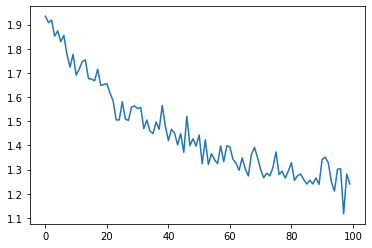

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show()


In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]): # length of name 
            output, hidden = rnn(line_tensor[i], hidden) # current character & prev hidden

        guess = category_from_output(output)
        print(guess)

while True:
    sentence = input("Input: ")
    if sentence == "quit":
        break
    
    predict(sentence)

Input: Acker

> Acker
German
Input: Adler

> Adler
German
Input: Abba

> Abba
Japanese
Input: Abbadelli

> Abbadelli
Italian
Input: Abaimov

> Abaimov
Russian
Input: Bao

> Bao
Chinese
Input: Bai

> Bai
Chinese
Input: Aodha

> Aodha
Arabic
Input: quit
